# JAK2 activity maximization with Deep Reinforcement Learning demo

In this experiment we will optimized parameters of pretrained generative RNN to produce molecules with maximized pIC50 for JAK2. We will use a combination of different optimization strategies including fine-tuning (aka transfer learning), policy gradient and policy gradient with experince replay.

## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch

In [4]:
use_cuda = torch.cuda.is_available()

In [5]:
import numpy as np

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from stackRNN import StackAugmentedGRU
from predictor import RandomForestQSAR
from data import GeneratorData
from data import PredictorData
from data import sanitize_smiles
from data import cross_validation_split
from data import save_smi_to_file
from reinforcement import Reinforcement
from ReplayMemory import ReplayMemory

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [30]:
threshold = 0.1

## Reading data

In [8]:
gen_data_path = './data/chembl_22_clean_1576904_sorted_std_final.smi'
jak2_data_path = './data/jak2_data.csv'

In [9]:
gen_data = GeneratorData(training_data_path=gen_data_path, use_cuda=use_cuda)

In [10]:
jak2_data = PredictorData(path=jak2_data_path, use_cuda=use_cuda, cols=[0, 1])

In [11]:
jak2_data.binarize(threshold=7.0)

(array([6861.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8487.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

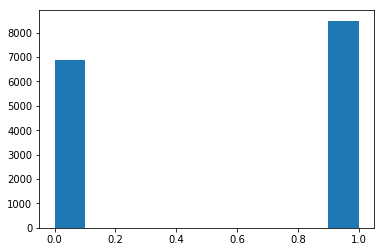

In [12]:
plt.hist(jak2_data.binary_labels)

In [13]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
char2idx = {}
gen_data.load_dictionary(tokens, char2idx)
jak2_data.load_dictionary(tokens, char2idx)

In [14]:
jak2_data.n_characters

45

## Util functions

**plot_hist** function plots histogram of predicted properties and a vertical line for thershold.

In [15]:
def plot_hist(prediction, n_to_generate, threshold):
    print("Mean value of predictions:", prediction.mean())
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    print("Proportion > threshold:", len(np.where(prediction >= threshold)[0])/len(prediction))
    plt.hist(prediction)
    plt.axvline(x=threshold, color='red')
    plt.xlabel('Predicted pIC50')
    plt.title('Distribution of predicted logP for generated molecules')
    plt.show()

**estimate_and_update** function:

1) generates n_to_generate number of SMILES strings

2) filters invalid SMILES

3) predicts logP for valid SMILES

4) plots histogram of predicted logP

5) Updates data structure for fine-tuning (aka transfer learning)

6) Pushes newly generated SMILES to experience replay pool

6) Returns valid SMILES and their predicted logPs

In [16]:
def estimate_and_update(n_to_generate):
    generated = []
    for _ in range(n_to_generate):
        generated.append(my_generator.evaluate(gen_data)[1:-1])
    
    sanitized = list(np.unique(sanitize_smiles(generated))[1:])
    smiles, prediction, nan_smiles = jak2_predictor.predict(sanitized)
    plot_hist(prediction, n_to_generate, threshold)
    
    for i in np.where(prediction >=threshold)[0]:
        transfer_pool.append('<' + smiles[i] + '>')
    
    save_smi_to_file(transfer_data_path, transfer_pool)
    transfer_data.update_data(transfer_data_path)
    
    for i in range(len(transfer_data.file)):
        replay.push(transfer_data.file[i])
        
    return smiles, prediction

## Initializing models

Initialize stack-augmented generative RNN:

In [17]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
lr = 0.01

my_generator = StackAugmentedGRU(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, stack_width=stack_width,
                                 stack_depth=stack_depth, use_cuda=use_cuda, n_layers=1,
                                 optimizer='Adadelta', lr=lr)

if use_cuda:
    my_generator = my_generator.cuda()

Load pretrained parameters into the model:

In [28]:
my_generator.load_model('./checkpoints/generator/checkpoint_biggest')

Initialize random forest predictive model:

In [19]:
jak2_predictor = RandomForestQSAR(model_type='classifier', n_estimators=100, n_ensemble=5)

Load pretrained parameters into the model:

In [20]:
jak2_predictor.load_model('./checkpoints/JAK2/')

Uncomment cell below to train RF from scratch:

In [21]:
#cross_val_data, cross_val_labels = cross_validation_split(jak2_data.smiles, jak2_data.binary_labels)
#cv_metric, metric_type = jak2_predictor.fit_model(PredictorData, cross_val_data, cross_val_labels)
#jak2_predictor.save_model('./checkpoints/JAK2/')

Initialize reinforcement object for biasing properties and experience replay pool:

In [22]:
RL = Reinforcement(my_generator, jak2_predictor)
replay = ReplayMemory(capacity=10000)

Initialize data object for fine-tuning (aka transfer learning):

In [23]:
transfer_data_path = './data/jak2_transfer_data.smi'
f = open(transfer_data_path, 'w')
f.close()
transfer_pool = []
transfer_data = GeneratorData(transfer_data_path)
transfer_data.load_dictionary(tokens, char2idx)

Estimate unbiased SMILES and update replay pool and transfer data:

/home/mariewelt/Notebooks/PyTorch/DeNovo/stackRNNCopy1.py:239: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  stack_controls = F.softmax(stack_controls)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:167: UserWarning: Unsanitized SMILES string: lc1ccc(Cl)cc1NC(=O)CN1C(=O)C2CC=CCC2C(=O)N1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:167: UserWarning: Unsanitized SMILES string: CCCCNC(=O)c1ccc(1)C1=C(O)C(=O)c2ccccc2N1c1ccc(cc1)C(O)=O
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:167: UserWarning: Unsanitized SMILES string: eC1C(=O)N(C=C1OCCOCc1ccc(cc1)N1CCC(CC1)c1ccccc1)C(O)=O
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:167: UserWarning: Unsanitized SMILES string: OC(=O)CCCCc1ccc(OCCc2coc(n2)-c2ccc-3ccnc3c2)

Mean value of predictions: 0.003558455950255495
Proportion of valid SMILES: 0.81215
Proportion > threshold: 0.009173182293911224


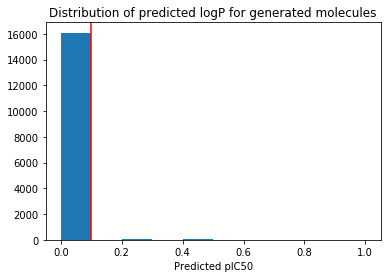

In [24]:
smiles_unbiased, prediction_unbiased = estimate_and_update(n_to_generate=20000)

In [25]:
for i in np.where(prediction_unbiased >=threshold)[0]:
        transfer_pool.append('<' + smiles_unbiased[i] + '>')
    
save_smi_to_file(transfer_data_path, transfer_pool)
transfer_data.update_data(transfer_data_path)

In [26]:
for i in range(len(jak2_data.smiles)):
    replay.push(jak2_data.smiles[i])
for i in range(len(transfer_data.file)):
    replay.push(transfer_data.file[i])

## Train the model

In [44]:
rewards = []
n_to_generate = 1000
n_policy_replay = 10
n_policy = 5
n_transfer = 500
n_iterations = 5
prediction_log = []

for _ in range(n_iterations):
     
    ### Transfer learning 
    RL.transfer_learning(transfer_data, n_epochs=n_transfer)
    _, prediction = estimate_and_update(n_to_generate)
    prediction_log.append(prediction)
    if len(np.where(prediction >= threshold)[0])/len(prediction) > 0.15:
        threshold = min(threshold + 0.05, 0.8)

    ### Policy gtadient with experience replay 
    for _ in range(n_policy_replay):
        rewards.append(RL.policy_gradient_replay(gen_data, replay, threshold=threshold, n_batch=10))
        print(rewards[-1])
    
    _, prediction = estimate_and_update(n_to_generate)
    prediction_log.append(prediction)
    if len(np.where(prediction >= threshold)[0])/len(prediction) > 0.15:
        threshold = min(threshold + 0.05, 0.8)
    
    ### Policy graient without experinece replay 
    for _ in range(n_policy):
        rewards.append(RL.policy_gradient(gen_data, threshold=threshold, n_batch=10))
        print(rewards[-1]) 

    _, prediction = estimate_and_update(n_to_generate)
    prediction_log.append(prediction)
    if len(np.where(prediction >= threshold)[0])/len(prediction) > 0.15:
        threshold = min(threshold + 0.05, 0.8)

/home/mariewelt/Notebooks/PyTorch/DeNovo/stackRNNCopy1.py:239: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

In [ ]:
smiles_biased, prediction_biased = estimate_and_update(n_to_generate=10000)

/home/mariewelt/Notebooks/PyTorch/DeNovo/stackRNNCopy1.py:239: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(array([ 548.,    0.,  332.,    0.,  327.,  386.,    0.,    0.,  585.,
        2694.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

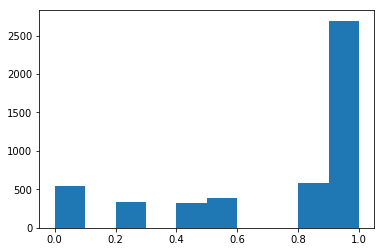

In [45]:
plt.hist(prediction_biased)

## Estimating similarity of biased and training datasets

In [46]:
generated_mols = [Chem.MolFromSmiles(sm) for sm in smiles_biased]
generated_fps = [FingerprintMols.FingerprintMol(x) for x in generated_mols]

In [35]:
jak2_mols = [Chem.MolFromSmiles(sm) for sm in jak2_data.smiles]
jak2_fps = [FingerprintMols.FingerprintMol(x) for x in jak2_mols]

In [56]:
#sim = []
#sim_smiles = []
#sim_labels = []
for fp1 in generated_fps[2521:]:
    max_sim = 0.0
    for j in range(len(jak2_fps)):
        fp2 = jak2_fps[j]
        tmp = DataStructs.FingerprintSimilarity(fp1,fp2)
        if tmp > max_sim:
            max_sim = tmp
            tmp_sm = jak2_data.smiles[j]
            tmp_label = jak2_data.property[j]
    sim.append(max_sim)
    sim_smiles.append(tmp_sm)
    sim_labels.append(tmp_label)

4872


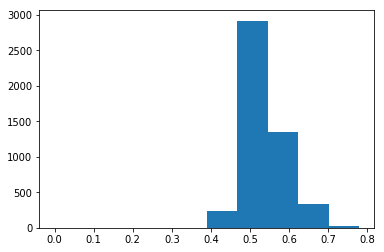

In [57]:
plt.hist(sim)
print(len(sim))

In [59]:
for i in range(len(smiles_biased)):
    if prediction_biased[i] == 1.0:
        print(smiles_biased[i])

CC(=O)N1CCC(n2cc(-c3ccc4ccccc4n3)cn2)CC1
CC(C)CCNC(=O)c1nnc(Nc2ccc(Cl)cc2)nc1N1CCC(C)CC1
CC(C)CNC(=O)c1ccc(-c2cnc(Nc3ccc(Nc4ccc(Cl)cc4)nn3)nn2)cc1
CC(Cc1ccc(F)cc1)N1CCC(n2ccc(-c3ccccn3)n2)C1
CC1CC(Nc2cnc(Nc3ccc(CNc4ccc(OCc5ccccc5F)cc4)nc3)nn2)C(O)C1O
CC1CC(c2nc(Nc3ccc(Cl)cc3)nnc2-c2ccc(Nc3ccc(O)cc3)nn2)C1
CC1CCC(CC2CCC(CO)C2)Nc2nc(Nc3ccc(NCc4ccc(Cl)cc4)nn3)nnc2C(=O)N1CCOCCO
CC1CCC(CCO)CCN2C(=O)c3nnc(Nc4ccc(Cl)cc4)nc3N(CC1)N2C(=O)Nc1ccccc1
CC1CCC(CNc2nc(Nc3ccc(Cl)cc3)nnc2-c2ccc(Nc3ccc(Nc4ccc(F)cc4)nc3)nn2)C1
CC1CCC(Nc2cnc(Nc3ccc(Cl)cc3)nn2)Cc2cc(OC(F)(F)F)ccc21
CC1CCC(Nc2nc(Nc3cc(Cl)cc(Cl)c3)nnc2-c2ccc(Nc3ccc(F)cc3)nn2)C1
CC1CCC(Nc2nc(Nc3ccc(C(=O)Nc4ccc(F)cc4)nn3)nnc2N2CCC(CCO)CC2)C1
CC1CCC(Nc2nc(Nc3ccc(Cl)cc3)nnc2-c2ccc(Nc3ccc(Cl)cc3)nn2)C1
CC1CCC(Nc2nc(Nc3ccc(Cl)cc3)nnc2-c2ccc(Nc3ccc(F)cc3)nn2)C1
CC1CCC(Nc2nc(Nc3ccc(Cl)cc3)nnc2-c2ccc(Nc3ccc(F)cc3)nn2)CC1
CC1CCC(Nc2nc(Nc3ccc(Cl)cc3)nnc2-c2ccc(Nc3ccc(Nc4ccc(Cl)cc4)nn3)nn2)C1
CC1CCC(Nc2nc(Nc3ccc(Cl)cc3)nnc2-c2ccc(Nc3ccc(Nc4ccc(F)cc4)nc3)

In [41]:
save_smi_to_file('/home/mariewelt/Notebooks/PyTorch/DeNovo/generated_compounds/jak2_maximized.smi', smiles_biased)

True

In [60]:
torch.save(my_generator.state_dict(), './checkpoints/generator/jak2_max')

In [ ]:
for i in range(100):
    jak2_compounds = []
    while (len(jak2_compounds) <= 1000):
        sm = my_generator.evaluate(gen_data, temperature=0.6)[1:-1]
        clean_sm, pred, nan_sm = jak2_predictor.predict([sm])
        if len(clean_sm) > 0 and pred[0] >= 0.8:
            jak2_compounds += clean_sm
    save_smi_to_file('./generated_compounds/jak2_v1/' + str(i) + '.txt', jak2_compounds)
    print(str(i*1000) + ' SMILES generated')

/home/mariewelt/Notebooks/PyTorch/DeNovo/stackRNNCopy1.py:239: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:141: UserWarning: Unable to calculate Fingerprint
  warnings.warn('Unable to calculate Fingerprint', UserWarning)


0 SMILES generated
1000 SMILES generated
2000 SMILES generated
3000 SMILES generated
4000 SMILES generated
5000 SMILES generated
6000 SMILES generated
7000 SMILES generated
8000 SMILES generated
9000 SMILES generated
10000 SMILES generated
11000 SMILES generated
12000 SMILES generated
13000 SMILES generated
14000 SMILES generated
15000 SMILES generated
16000 SMILES generated
17000 SMILES generated
18000 SMILES generated
19000 SMILES generated
20000 SMILES generated
21000 SMILES generated
22000 SMILES generated
23000 SMILES generated
24000 SMILES generated
25000 SMILES generated
26000 SMILES generated
27000 SMILES generated
28000 SMILES generated
29000 SMILES generated
30000 SMILES generated
31000 SMILES generated
32000 SMILES generated
33000 SMILES generated
34000 SMILES generated
35000 SMILES generated
36000 SMILES generated
37000 SMILES generated
38000 SMILES generated
39000 SMILES generated
40000 SMILES generated
41000 SMILES generated
42000 SMILES generated
43000 SMILES generated
4

In [76]:
jak2_compounds

['CC1CCC(c2cnc(Nc3ccc(Nc4ccc(F)cc4)nn3)nn2)C(O)C1O',
 'Fc1ccccc1CNc1ccc(Nc2nnc(Nc3ccccc3)c3ccccc23)nn1',
 'Fc1ccc(Nc2ncc(-c3ccc(Nc4ccc(F)cc4)nn3)nn2)cc1',
 'Fc1ccc(Nc2ccc(Nc3ncc(-c4ccc(F)cc4)nn3)nn2)cc1',
 'Fc1ccc(Nc2nc(Nc3ccc(Cl)cc3)nnc2-c2ccc(F)cc2)nn1',
 'Fc1ccc(Nc2ccc(Nc3ncc(-c4ccc(F)cc4)nn3)nn2)cc1',
 'Fc1ccc(-c2cnc(Nc3ccc(Nc4ccc(F)cc4)nn3)nn2)cc1',
 'Fc1ccccc1CN1CCC(n2ccc(-c3ccccn3)n2)C1',
 'FCC1CCN(c2nc(Nc3ccc(Cl)cc3)nnc2-c2ccc(Nc3ccc(F)cc3)nn2)C1',
 'OCC1CCC(c2nc(Nc3cccc(Cl)c3)nnc2-c2ccc(Nc3ccc(F)cc3)nn2)C1',
 'Fc1ccccc1CN1CCC(n2ccc(-c3cccnc3)n2)C1',
 'Fc1ccc(Nc2ccc(Nc3ncc(-c4ccc(F)cc4)nn3)cn2)cc1',
 'C1CCN(c2nc(Nc3ccc(Cl)cc3)nnc2-c2ccc(Nc3ccc(F)cc3)nn2)C1',
 'Fc1ccc(-c2cnc(Nc3ccc(Nc4ccc(F)cc4)nn3)nn2)cc1',
 'Fc1ccc(Nc2ncc(Nc3ccc(-c4ccc(F)cc4)nn3)nn2)cc1',
 'CC1CCN(c2nc(Nc3ccc(Cl)cc3)nnc2-c2ccc(Nc3ccc(F)cc3)nn2)CC1',
 'CC1CCN(c2nc(Nc3ccc(Cl)cc3)nnc2-c2ccc(Nc3ccc(F)cc3)nn2)C1',
 'Fc1ccc(Nc2ccc(Nc3nnc(Nc4ccc(Cl)cc4)nn3)c(NS(=O)(=O)c3ccccc3)n2)cc1',
 'Fc1ccc(Nc2nc(Nc3ccc(Cl)cc3)nn